In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import re
from textblob import TextBlob
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Explanation**

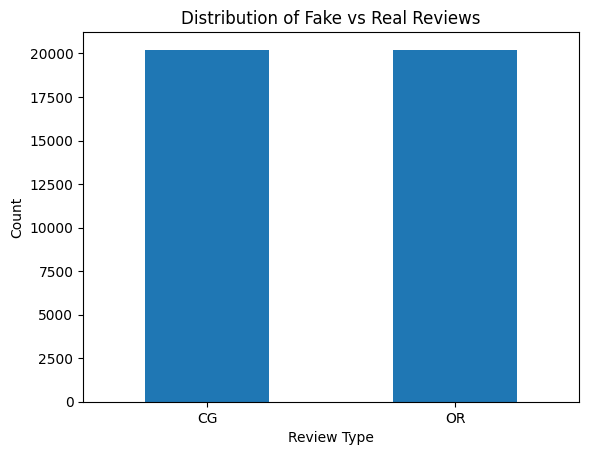

In [ ]:
# Load dataset
# Distribution of fake vs real reviews
df = pd.read_csv('/content/drive/MyDrive/AmazonReviews/Datasets/fake reviews dataset.csv')

label_counts = df['label'].value_counts()

# Plot the distribution
label_counts.plot(kind='bar')
plt.title('Distribution of Fake vs Real Reviews')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Data Cleaning and Preprocessing**

In [ ]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = nlp.Defaults.stop_words

# Define the preprocessing function
def preprocess_review_spacy(text):
    # Check if text is a string, if not return empty string
    if not isinstance(text, str):
        return ''

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization using SpaCy
    doc = nlp(text)

    # Remove stop words using SpaCy stopwords
    tokens = [token.text for token in doc if token.text not in spacy_stopwords]

    # Lemmatization
    tokens = [token.lemma_ for token in doc if token.text not in spacy_stopwords]

    return " ".join(tokens)


# Remove duplicates
df= df.drop_duplicates()

# Handle NaN values in 'text_' column
df['text_'] = df['text_'].fillna('')

# Apply the preprocessing function
df['text_'] = df['text_'].apply(lambda x: preprocess_review_spacy(x))


<ipython-input-7-d41f8cd9e0b6>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_'] = df['text_'].fillna('')


**Features Extraction(TF_IDF)and Split Dataset(20:80)**

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# TF-IDF Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['text_'])

# Split Dataset(20:80)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Train and Evaluation Machine Leaning(Random Forest,Logistic Regression,Naive Bayes and SVM)**

In [ ]:
# Train and Evaluate ML Models
for name, model in [
    ("Random Forest", RandomForestClassifier()),
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Naive Bayes", MultinomialNB()),
    ("SVM", SVC(probability=True))
]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(f"Precision: {precision_score(y_test, preds, average='binary'):.4f}")
    print(f"Recall: {recall_score(y_test, preds, average='binary'):.4f}")
    print(f"F1 Score: {f1_score(y_test, preds, average='binary'):.4f}")


Random Forest Metrics:
Accuracy: 0.8310
Precision: 0.8494
Recall: 0.8034
F1 Score: 0.8258

Logistic Regression Metrics:
Accuracy: 0.8516
Precision: 0.8468
Recall: 0.8573
F1 Score: 0.8520

Naive Bayes Metrics:
Accuracy: 0.8370
Precision: 0.8516
Recall: 0.8148
F1 Score: 0.8328

SVM Metrics:
Accuracy: 0.8709
Precision: 0.8623
Recall: 0.8816
F1 Score: 0.8719


**Train and Evaluation Deep Learning(LSTM)**

In [ ]:
# Tokenization for DL
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text_'])
X_seq = tokenizer.texts_to_sequences(df['text_'])

# Padding
max_length = 100
X_pad = pad_sequences(X_seq, maxlen=max_length)

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# LSTM Model
lstm_model = Sequential([
    Embedding(5000, 128, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy')
lstm_model.fit(X_train_pad, y_train_pad, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test_pad))
lstm_preds = (lstm_model.predict(X_test_pad) > 0.5).astype('int32')
print("LSTM Accuracy:", accuracy_score(y_test_pad, lstm_preds))
print("LSTM Precision:", precision_score(y_test_pad, lstm_preds, average='binary'))
print("LSTM Recall:", recall_score(y_test_pad, lstm_preds, average='binary'))
print("LSTM F1 Score:", f1_score(y_test_pad, lstm_preds, average='binary'))


Epoch 1/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.4658 - val_loss: 0.2868
Epoch 2/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2407 - val_loss: 0.2601
Epoch 3/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1790 - val_loss: 0.2662
Epoch 4/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1366 - val_loss: 0.2889
Epoch 5/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1088 - val_loss: 0.3439
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Accuracy: 0.8887926768926274
LSTM Precision: 0.900460593654043
LSTM Recall: 0.8734177215189873
LSTM F1 Score: 0.8867330225526018


**Tuning Deep Learning(LSTM)**

In [ ]:
# Define parameters to tune
lstm_params = {
    "embedding_dim": [50, 100, 128],
    "lstm_units": [64, 128],
    "dropout": [0.2, 0.3],
    "learning_rate": [0.001, 0.01]
}

# Function to build and train LSTM
def build_lstm(embedding_dim, lstm_units, dropout, learning_rate, input_length):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=embedding_dim, input_length=input_length),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Tokenization and padding
max_length = 100
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text_'])
X_seq = tokenizer.texts_to_sequences(df['text_'])
X_pad = pad_sequences(X_seq, maxlen=max_length)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # DL labels

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# LSTM Hyperparameter Tuning
best_lstm_score = 0
best_lstm_params = None

# Loop through all combinations of parameters
for embedding_dim in lstm_params["embedding_dim"]:
    for lstm_units in lstm_params["lstm_units"]:
        for dropout in lstm_params["dropout"]:
            for learning_rate in lstm_params["learning_rate"]:
                print(f"Training LSTM with params: embedding_dim={embedding_dim}, lstm_units={lstm_units}, dropout={dropout}, learning_rate={learning_rate}")

                # Build and train model
                lstm_model = build_lstm(embedding_dim, lstm_units, dropout, learning_rate, max_length)
                lstm_model.fit(X_train_pad, y_train_pad, epochs=5, batch_size=32, verbose=0)

                # Make predictions
                preds = (lstm_model.predict(X_test_pad) > 0.5).astype('int32')

                # Calculate metrics
                accuracy = accuracy_score(y_test_pad, preds)
                precision = precision_score(y_test_pad, preds)
                recall = recall_score(y_test_pad, preds)
                f1 = f1_score(y_test_pad, preds)

                # Print results for current parameters
                print(f"Accuracy: {accuracy:.4f}")
                print(f"Precision: {precision:.4f}")
                print(f"Recall: {recall:.4f}")
                print(f"F1 Score: {f1:.4f}")

                # Update best score if current F1 is better
                if f1 > best_lstm_score:
                    best_lstm_score = f1
                    best_lstm_params = (embedding_dim, lstm_units, dropout, learning_rate)

# Output the best parameters and score
print(f"Best LSTM Params: {best_lstm_params}")
print(f"Best LSTM F1 Score: {best_lstm_score:.4f}")


Training LSTM with params: embedding_dim=50, lstm_units=64, dropout=0.2, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8827
Precision: 0.9019
Recall: 0.8580
F1 Score: 0.8794
Training LSTM with params: embedding_dim=50, lstm_units=64, dropout=0.2, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8712
Precision: 0.8957
Recall: 0.8394
F1 Score: 0.8666
Training LSTM with params: embedding_dim=50, lstm_units=64, dropout=0.3, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8867
Precision: 0.8820
Recall: 0.8920
F1 Score: 0.8870
Training LSTM with params: embedding_dim=50, lstm_units=64, dropout=0.3, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8695
Precision: 0.8811
Recall: 0.8533
F1 Score: 0.8670
Training LSTM with params: embedding_dim=50, lstm_units=128, dropout=0.2, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8845
Precision: 0.9073
Recall: 0.8555
F1 Score: 0.8807
Training LSTM with params: embedding_dim=50, lstm_units=128, dropout=0.2, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8722
Precision: 0.8909
Recall: 0.8474
F1 Score: 0.8686
Training LSTM with params: embedding_dim=50, lstm_units=128, dropout=0.3, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8871
Precision: 0.9045
Recall: 0.8647
F1 Score: 0.8842
Training LSTM with params: embedding_dim=50, lstm_units=128, dropout=0.3, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8728
Precision: 0.8878
Recall: 0.8526
F1 Score: 0.8698
Training LSTM with params: embedding_dim=100, lstm_units=64, dropout=0.2, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8853
Precision: 0.8889
Recall: 0.8799
F1 Score: 0.8844
Training LSTM with params: embedding_dim=100, lstm_units=64, dropout=0.2, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8735
Precision: 0.8813
Recall: 0.8622
F1 Score: 0.8717
Training LSTM with params: embedding_dim=100, lstm_units=64, dropout=0.3, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8868
Precision: 0.8856
Recall: 0.8876
F1 Score: 0.8866
Training LSTM with params: embedding_dim=100, lstm_units=64, dropout=0.3, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8684
Precision: 0.8747
Recall: 0.8590
F1 Score: 0.8668
Training LSTM with params: embedding_dim=100, lstm_units=128, dropout=0.2, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8935
Precision: 0.9043
Recall: 0.8794
F1 Score: 0.8917
Training LSTM with params: embedding_dim=100, lstm_units=128, dropout=0.2, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8738
Precision: 0.8718
Recall: 0.8757
F1 Score: 0.8737
Training LSTM with params: embedding_dim=100, lstm_units=128, dropout=0.3, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8850
Precision: 0.8812
Recall: 0.8891
F1 Score: 0.8851
Training LSTM with params: embedding_dim=100, lstm_units=128, dropout=0.3, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8587
Precision: 0.8654
Recall: 0.8486
F1 Score: 0.8569
Training LSTM with params: embedding_dim=128, lstm_units=64, dropout=0.2, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8815
Precision: 0.8946
Recall: 0.8640
F1 Score: 0.8790
Training LSTM with params: embedding_dim=128, lstm_units=64, dropout=0.2, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8685
Precision: 0.8649
Recall: 0.8724
F1 Score: 0.8687
Training LSTM with params: embedding_dim=128, lstm_units=64, dropout=0.3, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8747
Precision: 0.9159
Recall: 0.8243
F1 Score: 0.8677
Training LSTM with params: embedding_dim=128, lstm_units=64, dropout=0.3, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8596
Precision: 0.8649
Recall: 0.8513
F1 Score: 0.8580
Training LSTM with params: embedding_dim=128, lstm_units=128, dropout=0.2, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8887
Precision: 0.8807
Recall: 0.8982
F1 Score: 0.8894
Training LSTM with params: embedding_dim=128, lstm_units=128, dropout=0.2, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8629
Precision: 0.8575
Recall: 0.8694
F1 Score: 0.8634
Training LSTM with params: embedding_dim=128, lstm_units=128, dropout=0.3, learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8872
Precision: 0.8967
Recall: 0.8744
F1 Score: 0.8854
Training LSTM with params: embedding_dim=128, lstm_units=128, dropout=0.3, learning_rate=0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8594
Precision: 0.8418
Recall: 0.8838
F1 Score: 0.8623
Best LSTM Params: (100, 128, 0.2, 0.001)
Best LSTM F1 Score: 0.8917
